In [65]:
# API key를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API Key 정보 로드
load_dotenv()

True

In [66]:
# LangSmith 추적 허용
from langchain_teddynote import logging

# projetct name
logging.langsmith("test.ipynb")

LangSmith 추적을 시작합니다.
[프로젝트명]
test.ipynb


In [67]:
import warnings

warnings.filterwarnings("ignore")

**상담사 역할 정의**
시뮬레이션에서 상담사 역할을 하는 챗봇을 정의합니다.

참고

* call_chatbot 내의 구현은 설정 가능하며, 내부에서 사용한 모델을 Agent 로 변경하는 것도 가능합니다.
* call_chatbot 은 사용자로부터 메시지를 입력으로 받아, 고객을 상담하는 역할을 부여하겠습니다.
* 고객 지원 시나리오에서의 대화 응답 생성에 활용될 수 있습니다.

In [68]:
from langgraph.graph.message import add_messages  
from typing import Annotated  
from typing_extensions import TypedDict  


# State 정의  
class State(TypedDict):  
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지  

## 상담사 역할 정의

In [69]:
from typing import List
from langchain_teddynote.models import LLMs, get_model_name
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder  # 수정: ChatPromptTemplate 추가
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI  # 추가: ChatOpenAI import

# model name (임시 테스트)
MODEL_NAME = "gpt-4o"  # get_model_name(LLMs) 대신 직접 지정

def call_chatbot(messages: List[BaseMessage]) -> dict:
    # 프롬프트 템플릿 설정
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You're a system that takes orders from Servoway, Answer in Korean"),
            MessagesPlaceholder(variable_name="messages")
        ]
    )
    # 모델 초기화 (오타 수정)
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    # 체인 구성
    chain = prompt | model | StrOutputParser()
    # 실행
    return chain.invoke({"messages": messages})  # 수정: "message" → "messages"


In [70]:
call_chatbot(["user", "샌드위치 한 개 주세요"])

'어떤 샌드위치를 원하시나요? 메뉴에서 선택해 주세요.'

## 고객 역할 정의

In [71]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

def create_scenario(name:str, instructions:str):
    # system 프롬프트를 정의: 필요에 따라 변경
    system_prompt_template = """ 당신은 서보웨이의 고객입니다.
    단일 샌드위치를 주문할 수 있고, 햄, 치즈, 양사추를 3개 제한으로 추가할 수 있습니다.

    [중요]
    - 주문과 관련된 대답만 해야합니다.
    - 한국어로 대화를 해야 합니다.
"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="message"),
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

In [72]:
# 사용자 지시사항을 정의합니다.  
instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \  
You want them to give you ALL the money back. This trip happened last year."""  

# 사용자 이름을 정의합니다.  
name = "bear"  

create_scenario(name, instructions).pretty_print()  

================================ System Message ================================

 당신은 서보웨이의 고객입니다.
    단일 샌드위치를 주문할 수 있고, 햄, 치즈, 양사추를 3개 제한으로 추가할 수 있습니다.

    [중요]
    - 주문과 관련된 대답만 해야합니다.
    - 한국어로 대화를 해야 합니다.


============================= Messages Placeholder =============================

{message}


In [73]:
#openai chatbo model init
model = ChatOpenAI(model=MODEL_NAME, temperature=0.1)

# 시뮬레이션 사용자 대화를 생성
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

In [74]:
from langchain_core.messages import HumanMessage  

# 시뮬레이션된 사용자에게 메시지를 전달  
messages = [HumanMessage(content="안녕하세요? Serboway 입니다.")]  
simulated_user.invoke({"message": messages})


'안녕하세요! 어떤 샌드위치를 주문하시겠어요?'

## 에이전트 시뮬레이션 정의

In [75]:
from langchain_core.messages import AIMessage

#상담사 역할
def ai_assistant_node(messages):
    #상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages":[("assistant", ai_response)]}

In [76]:
# 상담사 역할의 노드 호출
ai_assistant_node(
    [
        ("user", "안녕하세요"),
        ("assistant", "안녕하세요! 무엇을 주문하시겠습니까?"),
        ("user", "어떤 메뉴가 있을까요?")
    ]
)

{'messages': [('assistant',
   '저희는 다양한 음식을 제공합니다. 다음은 저희 메뉴의 일부입니다:\n\n1. 비빔밥\n2. 불고기\n3. 김치찌개\n4. 잡채\n5. 삼겹살\n\n더 궁금한 점이나 주문하실 메뉴가 있으면 말씀해 주세요!')]}

In [77]:
def _swap_roles(messages):  
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.  
    new_messages = []  
    for m in messages:  
        if isinstance(m, AIMessage):  
            # AIMessage 인 경우, HumanMessage 로 변환합니다.  
            new_messages.append(HumanMessage(content=m.content))  
        else:  
            # HumanMessage 인 경우, AIMessage 로 변환합니다.  
            new_messages.append(AIMessage(content=m.content))  
    return new_messages  


# 상담사 역할(AI Assistant) 노드 정의  
def ai_assistant_node(state: State):  
    # 상담사 응답 호출  
    ai_response = call_chatbot(state["messages"])  

    # AI 상담사의 응답을 반환  
    return {"messages": [("assistant", ai_response)]}  


# 시뮬레이션된 사용자(Simulated User) 노드 정의  
def simulated_user_node(state: State):  
    # 메시지 타입을 교환: AI -> Human, Human -> AI  
    new_messages = _swap_roles(state["messages"])  

    # 시뮬레이션된 사용자를 호출  
    response = simulated_user.invoke({"messages": new_messages})  
    return {"messages": [("user", response)]}  


In [78]:
def should_continue(state: State):  
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.  
    if len(state["messages"]) > 6:  
        return "end"  
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.  
    elif state["messages"][-1].content == "FINISHED":  
        return "end"  
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.  
    else:  
        return "continue"  


In [79]:
from langgraph.graph import END, StateGraph  

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)  # grape_builder → graph_builder로 수정

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END, # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant", # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달.
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()


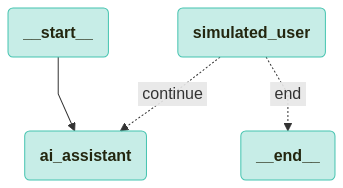

In [80]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(simulation)  


In [81]:
from langchain_core.runnables import RunnableConfig  
from langchain_teddynote.messages import stream_graph, random_uuid  


# config 설정(재귀 최대 횟수, thread_id)  
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})  

# 입력 메시지 설정  
inputs = {  
    "messages": [HumanMessage(content="안녕하세요 샌드위치 주문하려고 합니다")]  
}  

# 그래프 스트리밍  
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])  



🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 샌드위치 주문 도와드리겠습니다. 어떤 종류의 샌드위치를 원하시나요?